In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [3]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [4]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [102]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()
def gradient_function(actor, critic):
    params = actor.trainable_weights
    # placeholder
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    ts_input = tf.placeholder(tf.float32, shape=(None, 1))
    values_input = tf.placeholder(tf.float32, shape=(None, 1))
    
    # q_func gradient tensor
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    obj1 = tf.multiply(K.exp(- alpha * ts_input), critic_output_tensor)
    loss1 = -K.sum(obj1)
    gradient_for_q = dummy_optimizer.get_gradients(loss1, params)
    
    # discount factor gradient tensor
    discount = tf.expand_dims(- tf.exp(- alpha * actor_output[:,1]), 1)
    weights = tf.multiply(K.exp(- alpha * ts_input), values_input) # param勾配ないならok
    obj2 = tf.multiply(weights, discount)
    loss2 = K.sum(obj2)
    gradient_for_d = dummy_optimizer.get_gradients(loss2, params)
    
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    func = K.function([state_input, ts_input, values_input], gradient_tensor)
    
    return func

def gradient(states, ts, values, gradient_func):
    gradient = gradient_func([states, ts, values])
    return gradient


# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [8]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, batch_size=32, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def policy_gradient(actor, critic, target_critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    tmp = []
    for i in range(len(log) - 1):
        tmp.append([log[i][0], log[i][1], log[i+1][0]])
    tmp = np.array(tmp)
    states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
    values = target_critic.predict_on_batch([actor.predict_on_batch(np.array(next_states).reshape(len(log)-1,1,2)), np.array(next_states).reshape(len(log)-1,1,2)])[:,0]
    pg = gradient(states, ts, values, next_states, actor, critic)
    pg = flatten_gradient(pg)
    return pg

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    return episode_reward


In [74]:
# replay buffer の実装
class replay_buffer():
    def __init__(self, n_limits=30000):
        self.n_limits = n_limits
        self.memory = []
        
    def store(self, experience):
        # (s, a, r, s', e^-at)
        assert len(experience) == 5, 'shape error'
        self.memory.append(experience)
        if len(self.memory) >= self.n_limits:
            del self.memory[0]
        
    def sample(self, batch_size):
        batch = []
        idx_log = []
        while len(batch) < batch_size:
            idx = np.random.choice(range(len(self.memory)))
            candidate = self.memory[idx]
            if idx in idx_log:
                continue
            if np.random.rand() < candidate[-1]:
                idx_log.append(idx)
                batch.append(candidate)
        assert len(batch) == batch_size, ''
        return np.array(batch)
        
def reshape_data(data, mode=0):
    tmp = []
    for d in data:
        tmp.append(d)
    if mode==0:
        return np.array(tmp).reshape(len(data), 1, d.shape[0])
    else:
        return np.array(tmp).reshape(len(data), d.shape[0])

In [103]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [104]:
actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
target_actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
target_critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)
ev = evaluation(actor)
func = gradient_function(actor, critic)

In [106]:
print(f'value_function for initial policy = {ev}')

s = np.random.uniform(-7,7,2)
episode_time = 0
time_limit = 10.
batch_size = 32
buffer = replay_buffer(n_limits=30000)
n_warm_up = 1000
ev_log = [ev]
for i in range(2000):
    u, tau = actor.predict_on_batch(s.reshape(1,1,2))[0]
    r, s_prime = interaction(s, u, tau, env, ln=0.1)
    buffer.store([s, np.array([u, tau]), r, s_prime, np.exp(- alpha * episode_time)])
    episode_time += tau
    s = s_prime
    if episode_time >= time_limit:
        s = np.random.uniform(-7,7,2)
        episode_time = 0
    if i < n_warm_up:
        continue
    #print(f'{i-n_warm_up}-step')
    batch = buffer.sample(batch_size)
    critic, losses = td_learning(batch[:,:4], actor, critic, target_actor, target_critic, batch_size=batch_size, epoch=1)
    critic_input = [target_actor.predict_on_batch(reshape_data(batch[:,3])), reshape_data(batch[:,3])]
    values = target_critic.predict_on_batch(critic_input)
    pg = flatten_gradient(gradient(reshape_data(batch[:,0],1), batch[:,4], values, func))
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    ev = evaluation(actor)
    ev_log.append(ev)
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    print(f'{i}\r',end='')
    #print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    #print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -12.800075647708129


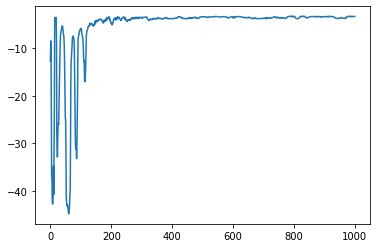

In [107]:
plt.plot(ev_log)

In [111]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
initial_state = np.array([4., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

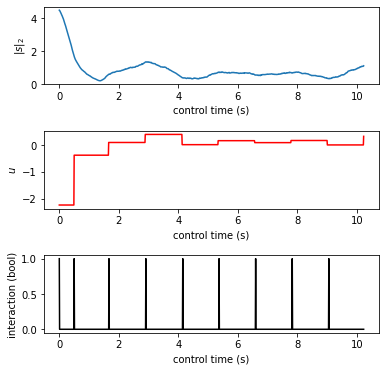

In [112]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [110]:
actor.save_weights('../saved_agent/learned_self_linear_proposed1_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_proposed1_critic.h5')

In [38]:
sr = '''
0-step
loss of critic is 0.07652541995048523, value_fuction V(s) = -4.422114582550648
|g| = 2.3382335684373374
1-step
loss of critic is 0.07875825464725494, value_fuction V(s) = -4.313053960194738
|g| = 4.403051531150942
2-step
loss of critic is 0.017230872064828873, value_fuction V(s) = -24.331910288861906
|g| = 0.4044792862066658
3-step
loss of critic is 0.029344214126467705, value_fuction V(s) = -33.239146413686974
|g| = 2.0199033959628383
4-step
loss of critic is 0.03964787349104881, value_fuction V(s) = -7.320187300266845
|g| = 2.167373383992968
5-step
loss of critic is 0.02375425584614277, value_fuction V(s) = -6.567042038495428
|g| = 2.09126927899128
6-step
loss of critic is 0.021715926006436348, value_fuction V(s) = -4.548285477323808
|g| = 2.8124241339025726
7-step
loss of critic is 0.01761675998568535, value_fuction V(s) = -3.7949908400174417
|g| = 0.8347615725447313
8-step
loss of critic is 0.0149616040289402, value_fuction V(s) = -3.391364696065595
|g| = 2.108433040656313
9-step
loss of critic is 0.014176708646118641, value_fuction V(s) = -3.3986792043846723
|g| = 0.18360081089242913
10-step
loss of critic is 0.024577131494879723, value_fuction V(s) = -3.677364432049576
|g| = 0.33470045700666395
11-step
loss of critic is 0.01561835315078497, value_fuction V(s) = -3.787606416117957
|g| = 13.19127377793931
12-step
loss of critic is 0.013484016060829163, value_fuction V(s) = -3.8862684985341613
|g| = 0.4194301782061841
13-step
loss of critic is 0.022904574871063232, value_fuction V(s) = -5.156389972583571
|g| = 0.4199933230452863
14-step
loss of critic is 0.009220286272466183, value_fuction V(s) = -21.42009669979436
|g| = 0.4801610856677542
15-step
loss of critic is 0.023257233202457428, value_fuction V(s) = -24.857406633293945
|g| = 0.37869170328178464
16-step
loss of critic is 0.027873706072568893, value_fuction V(s) = -22.308864710028466
|g| = 2.074680365217264
17-step
loss of critic is 15.423576354980469, value_fuction V(s) = -4.183781034585183
|g| = 1.111916073355107
18-step
loss of critic is 0.06367311626672745, value_fuction V(s) = -3.9175490456543574
|g| = 0.5102328580813945
19-step
loss of critic is 0.011864183470606804, value_fuction V(s) = -3.5071453658362977
|g| = 0.9213432577425813
20-step
loss of critic is 0.012601414695382118, value_fuction V(s) = -4.041365708369032
|g| = 24.031506706561817
21-step
loss of critic is 0.021553680300712585, value_fuction V(s) = -4.779892347366979
|g| = 1.4360628494203285
22-step
loss of critic is 0.025230251252651215, value_fuction V(s) = -11.811661475085488
|g| = 0.21231427030066483
23-step
loss of critic is 0.01918908953666687, value_fuction V(s) = -3.2041812725022565
|g| = 0.9354144700144718
24-step
loss of critic is 0.024259041994810104, value_fuction V(s) = -4.656847703132423
|g| = 0.6010187248607082
25-step
loss of critic is 14.594965934753418, value_fuction V(s) = -4.212388599248243
|g| = 3.721141785570537
26-step
loss of critic is 0.01217117439955473, value_fuction V(s) = -3.4739058005661976
|g| = 1.8264532399208313
27-step
loss of critic is 0.028286704793572426, value_fuction V(s) = -4.10545283721516
|g| = 7.757362622194666
28-step
loss of critic is 0.010958405211567879, value_fuction V(s) = -13.560654198054843
|g| = 0.6957491104151876
29-step
loss of critic is 0.006734691560268402, value_fuction V(s) = -3.4123937711429537
|g| = 0.8920662417109301
30-step
loss of critic is 0.01864231377840042, value_fuction V(s) = -9.434490478224156
|g| = 1.7708314675307513
31-step
loss of critic is 14.33439826965332, value_fuction V(s) = -10.183459855210172
|g| = 1.7501652323422427
32-step
loss of critic is 0.015153562650084496, value_fuction V(s) = -6.5237038547065
|g| = 6.062025609120797
33-step
loss of critic is 0.5749214291572571, value_fuction V(s) = -7.813161617481443
|g| = 1.0537099299020833
34-step
loss of critic is 0.015615452080965042, value_fuction V(s) = -5.37253465163995
|g| = 14.443860263922582
35-step
loss of critic is 0.009107867255806923, value_fuction V(s) = -3.584438725423034
|g| = 2.003729103596673
36-step
loss of critic is 0.05509542301297188, value_fuction V(s) = -3.6001644327566713
|g| = 3.1982031359258447
37-step
loss of critic is 0.0176492091268301, value_fuction V(s) = -3.604896841984741
|g| = 1.4286090715710695
38-step
loss of critic is 0.023610979318618774, value_fuction V(s) = -3.1314056179661622
|g| = 1.038568248922818
39-step
loss of critic is 0.027041234076023102, value_fuction V(s) = -3.147865083505494
|g| = 3.58683788015867
40-step
loss of critic is 0.024019822478294373, value_fuction V(s) = -3.041785266106516
|g| = 0.9447211239573732
41-step
loss of critic is 0.01019859779626131, value_fuction V(s) = -2.9576350926438053
|g| = 1.8272055649638381
42-step
loss of critic is 0.01729862578213215, value_fuction V(s) = -2.925842695763706
|g| = 0.7037236176630148
43-step
loss of critic is 0.018847202882170677, value_fuction V(s) = -3.008357382697079
|g| = 3.7213394748272877
44-step
loss of critic is 0.06099327281117439, value_fuction V(s) = -2.975153282343228
|g| = 0.9154631819213527
45-step
loss of critic is 0.01863606460392475, value_fuction V(s) = -2.9221580213464913
|g| = 2.667620606525006
46-step
loss of critic is 9.639552116394043, value_fuction V(s) = -3.214372647635666
|g| = 3.4335803728880534
47-step
loss of critic is 0.01412452943623066, value_fuction V(s) = -3.2061456638387327
|g| = 0.6150596172256917
48-step
loss of critic is 0.02056170254945755, value_fuction V(s) = -3.4473916557333304
|g| = 0.36345558052029214
49-step
loss of critic is 0.03286726772785187, value_fuction V(s) = -3.805821251978413
|g| = 0.8549708475428132
50-step
loss of critic is 0.027372824028134346, value_fuction V(s) = -3.925724734649536
|g| = 0.8067723697243312
51-step
loss of critic is 0.01697341725230217, value_fuction V(s) = -3.933536311703525
|g| = 9.9792301617067
52-step
loss of critic is 0.011360189877450466, value_fuction V(s) = -4.332310711117196
|g| = 1.1211450254013902
53-step
loss of critic is 0.008744115009903908, value_fuction V(s) = -4.51218870295703
|g| = 2.751356344457608
54-step
loss of critic is 0.023541945964097977, value_fuction V(s) = -4.878008891499528
|g| = 0.46225375658789225
55-step
loss of critic is 0.012370786629617214, value_fuction V(s) = -4.846004669371713
|g| = 2.351332665142931
56-step
loss of critic is 0.009842591360211372, value_fuction V(s) = -4.823834587641433
|g| = 1.1748337783292582
57-step
loss of critic is 0.009909036569297314, value_fuction V(s) = -4.5174687040535035
|g| = 1.9091960361574714
58-step
loss of critic is 1.3592145442962646, value_fuction V(s) = -4.911225118792695
|g| = 6.6378489880655085
59-step
loss of critic is 0.10264523327350616, value_fuction V(s) = -4.99890072969164
|g| = 0.4960798295432919
60-step
loss of critic is 0.013395620509982109, value_fuction V(s) = -5.234666033481061
|g| = 0.19604500019858928
61-step
loss of critic is 0.06978379189968109, value_fuction V(s) = -5.172016039782207
|g| = 1.068853651885576
62-step
loss of critic is 0.07024704664945602, value_fuction V(s) = -5.427478925891747
|g| = 0.28583955137354927
63-step
loss of critic is 0.022546369582414627, value_fuction V(s) = -4.938488459061217
|g| = 1.864236199329056
64-step
loss of critic is 0.022248201072216034, value_fuction V(s) = -4.516378794167617
|g| = 3.1872992418439714
65-step
loss of critic is 0.005661824718117714, value_fuction V(s) = -4.24178206391721
|g| = 0.6829718039812377
66-step
loss of critic is 0.00819612666964531, value_fuction V(s) = -3.866040658648897
|g| = 0.20255942880158687
67-step
loss of critic is 0.029551412910223007, value_fuction V(s) = -3.543692534949591
|g| = 0.48876421916908386
68-step
loss of critic is 0.009243354201316833, value_fuction V(s) = -3.466340028059194
|g| = 0.9848206489502495
'''

In [39]:
l = [-4.360907237200663]
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

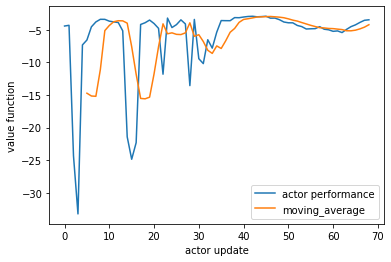

In [40]:
#rs = rs[15:]
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()